<a href="https://colab.research.google.com/github/Sreejoyee/quantum_machine_learning/blob/main/Neural_Network_Classifier_%26_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
%pip install qiskit
%pip install qiskit_machine_learning
%pip install pylatexenc

# Reference

- [Qiskit Machine Learning](https://qiskit.org/ecosystem/machine-learning/tutorials/02_neural_network_classifier_and_regressor.html)

importing packages

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

from qiskit.visualization import plot_bloch_vector

algorithm_globals.random_seed = 42


generating dataset

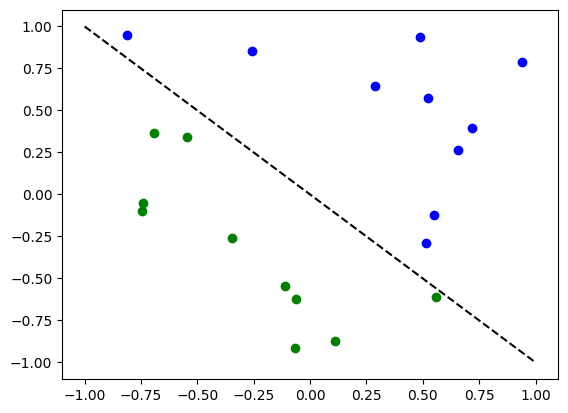

In [3]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

converting classical data to quantum data using zz feature map

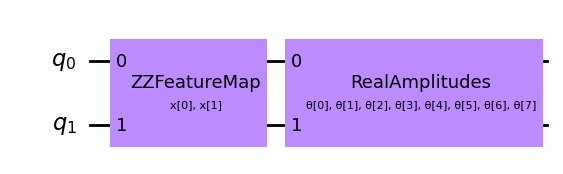

In [4]:
# construct QNN
qc = QuantumCircuit(2)
feature_map = ZZFeatureMap(2)
ansatz = RealAmplitudes(2)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw(output="mpl")

*Displaying the graph at each iteration*

In [5]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

# Create a quantum neural network

In [7]:
estimator_qnn = EstimatorQNN(
    circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters
)

In [8]:
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.23521988]])

In [9]:
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

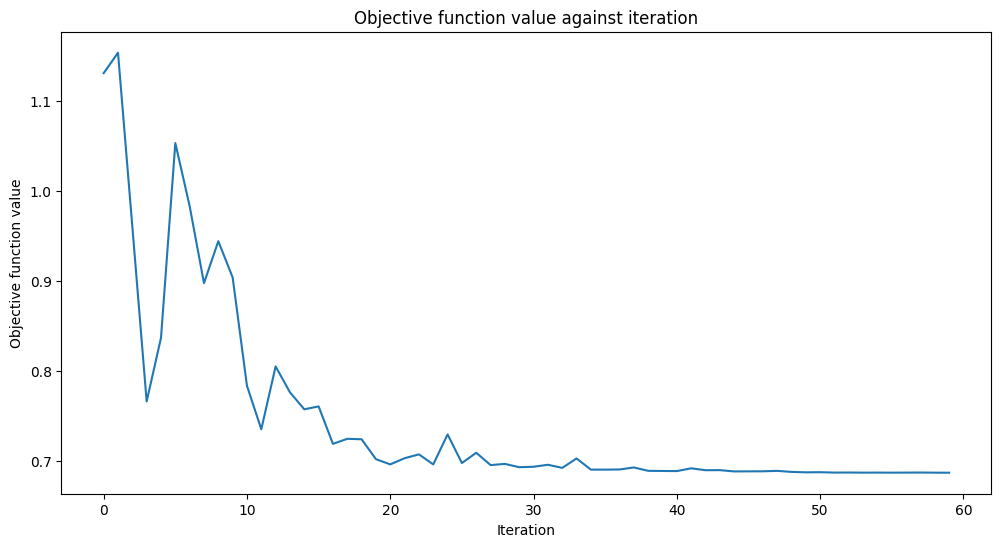

0.75

In [26]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)


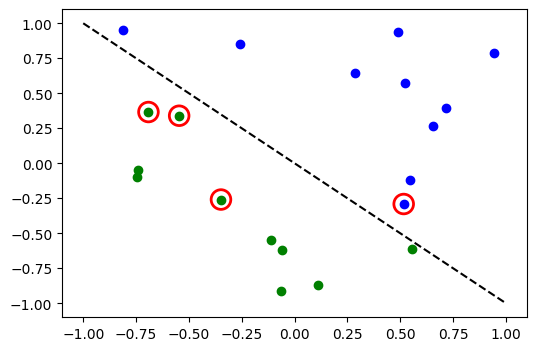

In [11]:
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [12]:
estimator_classifier.weights

array([ 0.86209107, -1.06526254, -0.10663602, -0.39086371,  1.0894299 ,
        0.59368219,  2.22731471, -1.04769663])

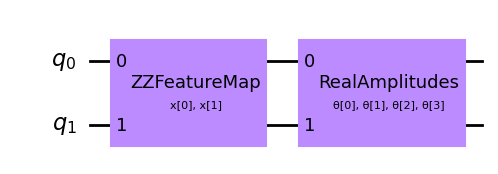

In [13]:
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output="mpl")


In [14]:
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.



In [15]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

In [16]:
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

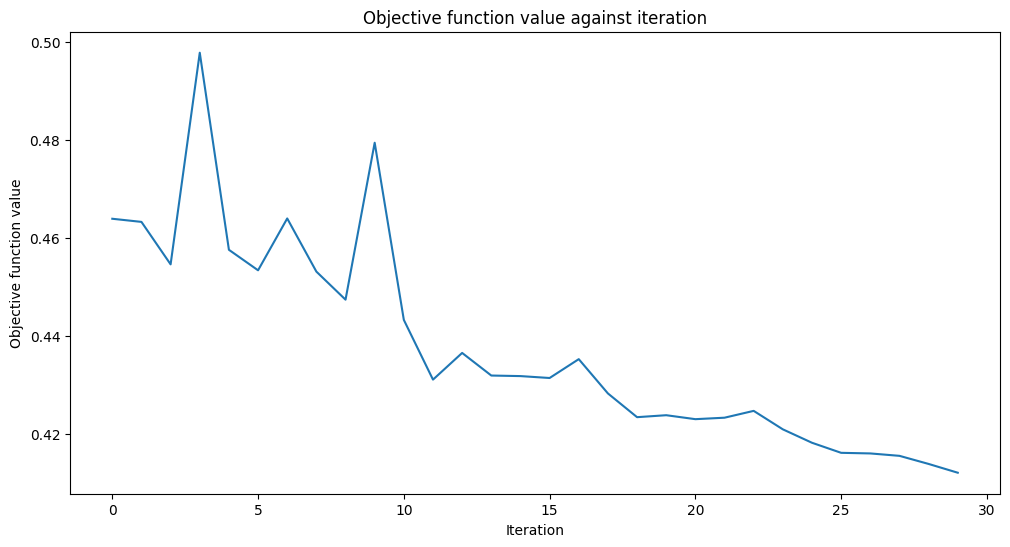

0.7

In [17]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)


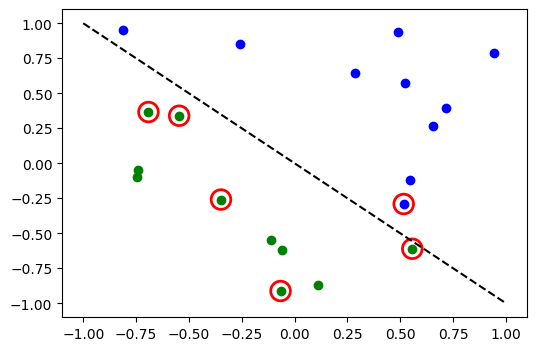

In [18]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In [19]:
sampler_classifier.weights

array([ 1.67198565,  0.46045402, -0.93462862, -0.95266092])

In [20]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(num_inputs)
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
)


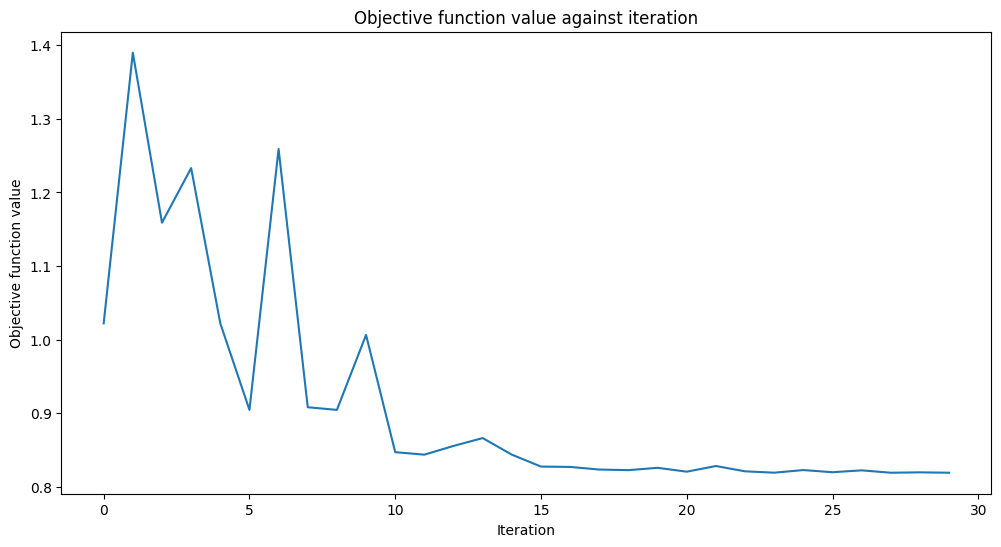

0.75

In [21]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_one_hot)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_one_hot)



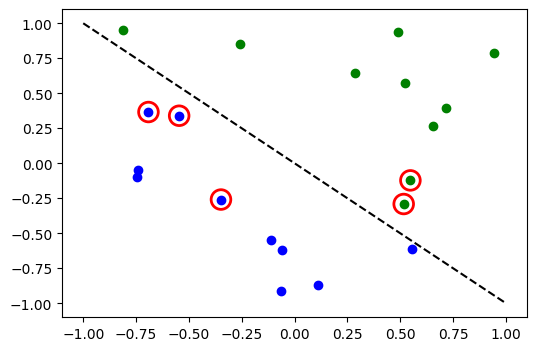

In [22]:
y_predict = vqc.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y_one_hot, y_predict):
    if y_target[0] == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if not np.all(y_target == y_p):
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()